## changing the dimensions and blockSize 

In [3]:
import tensorstore as ts
import numpy as np
import time
import matplotlib.pyplot as plt
import os

def calculate_dimensions(total_size_mb, block_size_mb, dtype):
    itemsize = np.dtype(dtype).itemsize
    
    total_elements = (total_size_mb * (1024 ** 2)) // itemsize
    block_elements = (block_size_mb * (1024 ** 2)) // itemsize

    fixed_dim = 1024
    scaled_dim = total_elements // fixed_dim
    block_scaled_dim = block_elements // fixed_dim
    
    return (scaled_dim, fixed_dim), (block_scaled_dim, fixed_dim)

def write_tensor(driver, file, driver_path, data_type, dimensions, block_size, compression, file_io_limit, file_io_sync):
    start_time = time.time()

    metadata = {
        'dataType': data_type,
        'dimensions': dimensions,
        'blockSize': block_size,
    }

    if compression != 'none':
        metadata['compression'] = {'type': compression}
        
    block_str = 'x'.join(str(x) for x in block_size)
    full_path = os.path.join(driver_path, block_str)
    
    kvstore = {
        'driver': file,
        'path': full_path,
    }
    
    if file == 'gcs':  
        kvstore['bucket'] = driver_path
        kvstore['path'] = f'dataset/{driver}/{block_str}'
        kvstore['gcs_request_concurrency'] = {'limit': file_io_limit}
    else:
        kvstore['file_io_concurrency'] = {'limit': file_io_limit}
        kvstore['file_io_sync'] = file_io_sync

    dataset = ts.open({
        'driver': driver,
        'kvstore': kvstore,
        'metadata': metadata,
        'create': True,
        'delete_existing': True,
    }).result()

    data = np.random.randint(0, 1001, size=dimensions).astype(data_type)
    dataset[...] = data

    elapsed_time_ms = round((time.time() - start_time) * 1000)
    print(f"N5 write - Block: {block_size} - Time: {elapsed_time_ms}ms")
    return elapsed_time_ms

def read_tensor(driver, file, driver_path, block_size, file_io_limit, file_io_sync):
    start_time = time.time()
    
    block_str = 'x'.join(str(x) for x in block_size)
    full_path = os.path.join(driver_path, block_str)
    
    kvstore = {
        'driver': file,
        'path': full_path,
    }
    
    if file == 'gcs':  
        kvstore['bucket'] = driver_path
        kvstore['path'] = f'dataset/{driver}/{block_str}'
        kvstore['gcs_request_concurrency'] = {'limit': file_io_limit}
    else:
        kvstore['file_io_concurrency'] = {'limit': file_io_limit}
        kvstore['file_io_sync'] = file_io_sync

    dataset = ts.open({
        'driver': 'n5',
        'kvstore': kvstore,
    }).result()

    data = dataset.read().result()
    elapsed_time_ms = round((time.time() - start_time) * 1000)
    print(f"N5 read - Block: {block_size} - Time: {elapsed_time_ms}ms")
    return elapsed_time_ms

def plot_results(block_sizes_mb, block_dims, write_times, read_times):
    plt.figure(figsize=(12, 6))
    x = np.arange(len(block_sizes_mb))
    width = 0.35
    
    plt.bar(x - width/2, write_times, width, label='Write', color='tab:red')
    plt.bar(x + width/2, read_times, width, label='Read', color='tab:blue')
    
    plt.xlabel('Block Size', fontsize=16, fontweight='bold')
    plt.ylabel('Time (ms)', fontsize=16, fontweight='bold')
    plt.title('N5 Performance by Block Size', fontsize=16, fontweight='bold')
    
    labels = [f"{mb}MB\n({dims[0]}x{dims[1]})" for mb, dims in zip(block_sizes_mb, block_dims)]
    plt.xticks(x, labels, fontsize=16, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')
    
    plt.legend(fontsize=16)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


## defining functions with separate open and read/write times

In [1]:
import tensorstore as ts
import numpy as np
import time
import matplotlib.pyplot as plt
import os

def calculate_dimensions(total_size_mb, block_size_mb, dtype):
    itemsize = np.dtype(dtype).itemsize
    total_elements = (total_size_mb * (1024 ** 2)) // itemsize
    block_elements = (block_size_mb * (1024 ** 2)) // itemsize
    fixed_dim = 1024
    scaled_dim = total_elements // fixed_dim
    block_scaled_dim = block_elements // fixed_dim
    return (scaled_dim, fixed_dim), (block_scaled_dim, fixed_dim)

def write_tensor(driver_path, data_type, dimensions, block_size, compression, file_io_limit, file_io_sync):
    total_start = time.time()
    
    metadata = {
        'dataType': data_type,
        'dimensions': dimensions,
        'blockSize': block_size,
    }

    if compression != 'none':
        metadata['compression'] = {'type': compression}
        
    block_str = 'x'.join(str(x) for x in block_size)
    full_path = os.path.join(driver_path, block_str)
    
    kvstore = {
        'driver': file,
        'path': full_path,
    }
    
    if file == 'gcs':  
        kvstore['bucket'] = driver_path
        kvstore['path'] = f'dataset/{driver}/{block_str}'
        kvstore['gcs_request_concurrency'] = {'limit': file_io_limit}
    else:
        kvstore['file_io_concurrency'] = {'limit': file_io_limit}
        kvstore['file_io_sync'] = file_io_sync

    open_start = time.time()
    dataset = ts.open({
        'driver': 'n5',
        'kvstore': kvstore,
        'metadata': metadata,
        'create': True,
        'delete_existing': True,
    }).result()
    open_time = time.time() - open_start

    data = np.random.randint(0, 1001, size=dimensions).astype(data_type)
    write_start = time.time()
    dataset[...] = data
    write_time = time.time() - write_start

    total_time_ms = round((time.time() - total_start) * 1000)
    print(f"N5 write - Block: {block_size} - Open: {open_time*1000:.2f}ms, Write: {write_time*1000:.2f}ms, Total: {total_time_ms}ms")
    return total_time_ms

def read_tensor(driver_path, block_size, file_io_limit, file_io_sync):
    total_start = time.time()

    block_str = 'x'.join(str(x) for x in block_size)
    full_path = os.path.join(driver_path, block_str)
    
    kvstore = {
        'driver': file,
        'path': full_path,
    }
    
    if file == 'gcs':  
        kvstore['bucket'] = driver_path
        kvstore['path'] = f'dataset/{driver}/{block_str}'
        kvstore['gcs_request_concurrency'] = {'limit': file_io_limit}
    else:
        kvstore['file_io_concurrency'] = {'limit': file_io_limit}
        kvstore['file_io_sync'] = file_io_sync

    open_start = time.time()
    dataset = ts.open({
        'driver': 'n5',
        'kvstore': kvstore,
    }).result()
    open_time = time.time() - open_start

    read_start = time.time()
    data = dataset.read().result()
    read_time = time.time() - read_start

    total_time_ms = round((time.time() - total_start) * 1000)
    print(f"N5 read - Block: {block_size} - Open: {open_time*1000:.2f}ms, Read: {read_time*1000:.2f}ms, Total: {total_time_ms}ms")
    return total_time_ms

def plot_results(block_sizes_mb, block_dims, write_times, read_times):
    plt.figure(figsize=(12, 6))
    x = np.arange(len(block_sizes_mb))
    width = 0.35
    
    plt.bar(x - width/2, write_times, width, label='Write', color='tab:red')
    plt.bar(x + width/2, read_times, width, label='Read', color='tab:blue')
    
    plt.xlabel('Block Size')
    plt.ylabel('Time (ms)')
    plt.title('N5 Performance by Block Size')
    
    labels = []
    for mb, dims in zip(block_sizes_mb, block_dims):
        labels.append(f"{mb}MB\n({dims[0]}x{dims[1]})")
    
    plt.xticks(x, labels)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


## trying out the extended time breakdown

N5 write - Block: (1024, 1024) - Time: 8006ms
N5 read - Block: (1024, 1024) - Time: 1253ms
N5 write - Block: (2048, 1024) - Time: 10692ms
N5 read - Block: (2048, 1024) - Time: 2581ms
N5 write - Block: (4096, 1024) - Time: 7447ms
N5 read - Block: (4096, 1024) - Time: 3011ms
N5 write - Block: (16384, 1024) - Time: 9257ms
N5 read - Block: (16384, 1024) - Time: 3479ms
N5 write - Block: (65536, 1024) - Time: 9532ms
N5 read - Block: (65536, 1024) - Time: 5106ms
N5 write - Block: (262144, 1024) - Time: 14734ms
N5 read - Block: (262144, 1024) - Time: 6871ms


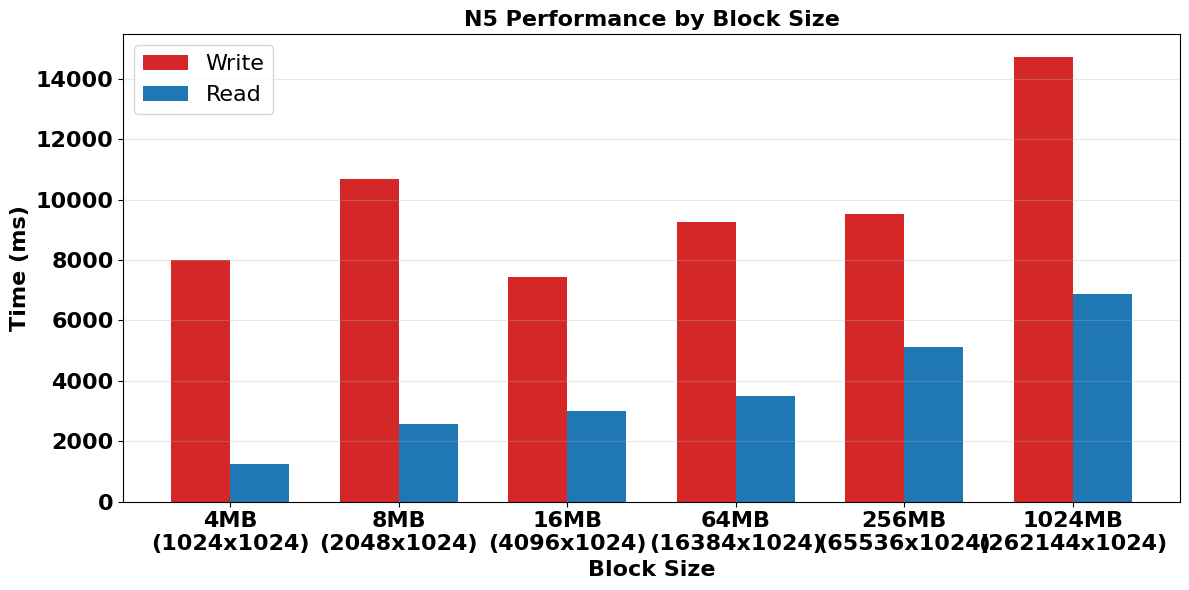

In [3]:
total_size_mb = 1024
block_sizes_mb = [4, 8, 16, 64, 256, 1024]
data_type = 'int32'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'none'
file_io_limit = 'shared'
file_io_sync = True

write_times = []
read_times = []
block_dims_list = []

for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
    
    write_times.append(write_time)
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

In [1]:
total_size_mb = 1024
# block_sizes_mb = [1, 4, 16, 16, 64, 256, 1024]
block_sizes_mb = [4, 8, 16, 64, 256, 1024]
data_type = 'int32'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'none'
file_io_limit = 'shared'
file_io_sync = True

write_times = []
read_times = []
block_dims_list = []

for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    
    read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
    
    write_times.append(write_time)
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

NameError: name 'calculate_dimensions' is not defined

## repeatations used to generate result

N5 write - Block: (256, 1024) - Time: 7633ms
N5 write - Block: (1024, 1024) - Time: 6842ms
N5 write - Block: (4096, 1024) - Time: 7456ms
N5 write - Block: (16384, 1024) - Time: 6600ms
N5 write - Block: (65536, 1024) - Time: 7930ms
N5 write - Block: (262144, 1024) - Time: 13018ms
N5 read - Block: (256, 1024) - Time: 1233ms
N5 read - Block: (1024, 1024) - Time: 1313ms
N5 read - Block: (4096, 1024) - Time: 3227ms
N5 read - Block: (16384, 1024) - Time: 3680ms
N5 read - Block: (65536, 1024) - Time: 5165ms
N5 read - Block: (262144, 1024) - Time: 8349ms
N5 write - Block: (256, 1024) - Time: 8987ms
N5 write - Block: (1024, 1024) - Time: 6244ms
N5 write - Block: (4096, 1024) - Time: 9354ms
N5 write - Block: (16384, 1024) - Time: 10028ms
N5 write - Block: (65536, 1024) - Time: 12259ms
N5 write - Block: (262144, 1024) - Time: 16121ms
N5 read - Block: (256, 1024) - Time: 2658ms
N5 read - Block: (1024, 1024) - Time: 2225ms
N5 read - Block: (4096, 1024) - Time: 4558ms
N5 read - Block: (16384, 1024) 

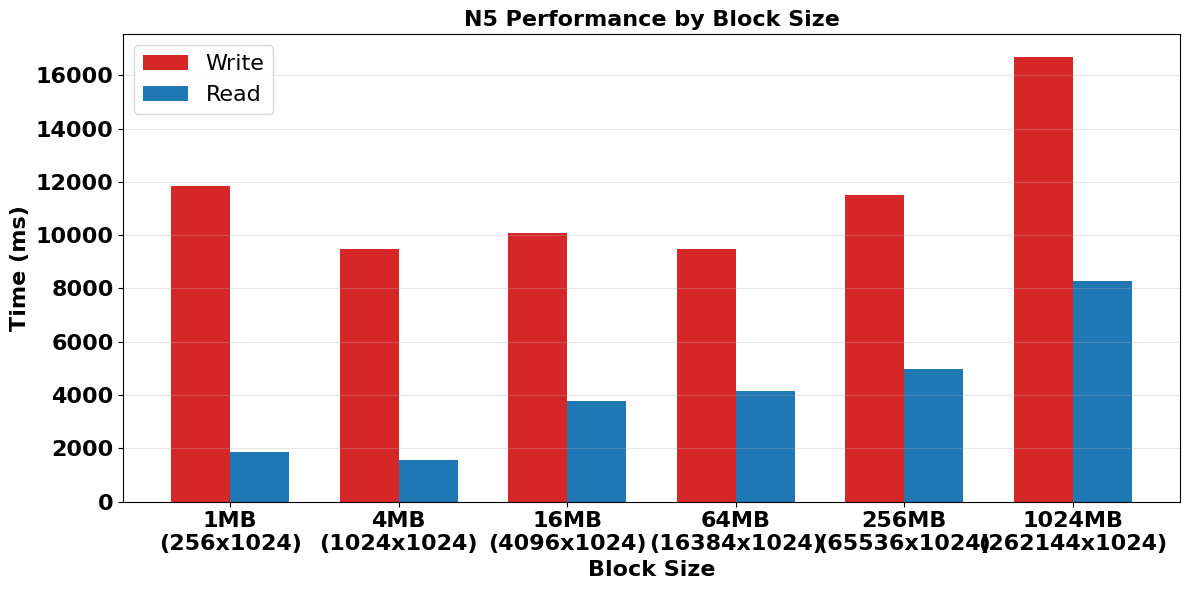

In [5]:
total_size_mb = 1024
block_sizes_mb = [1, 4, 16, 64, 256, 1024]
data_type = 'int32'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'none'
file_io_limit = 'shared'
file_io_sync = True
n = 5

write_times = [0] * len(block_sizes_mb)
read_times = [0] * len(block_sizes_mb)
block_dims_list = []

for i in range(n):
    for idx, block_mb in enumerate(block_sizes_mb):
        dims = calculate_dimensions(total_size_mb, block_mb, data_type)
        if i == 0:
            block_dims_list.append(dims[1])  # Only record once
        write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
        write_times[idx] += write_time

    for idx, block_mb in enumerate(block_sizes_mb):
        dims = calculate_dimensions(total_size_mb, block_mb, data_type)
        read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
        read_times[idx] += read_time

# Average the times
write_times = [wt / n for wt in write_times]
read_times = [rt / n for rt in read_times]

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)


N5 write - Block: (1024, 1024) - Time: 3972ms
N5 write - Block: (2048, 1024) - Time: 4064ms
N5 write - Block: (4096, 1024) - Time: 3530ms
N5 write - Block: (16384, 1024) - Time: 3383ms
N5 write - Block: (65536, 1024) - Time: 3131ms
N5 write - Block: (262144, 1024) - Time: 7007ms
N5 read - Block: (1024, 1024) - Time: 1305ms
N5 read - Block: (2048, 1024) - Time: 2487ms
N5 read - Block: (4096, 1024) - Time: 3314ms
N5 read - Block: (16384, 1024) - Time: 3454ms
N5 read - Block: (65536, 1024) - Time: 3801ms
N5 read - Block: (262144, 1024) - Time: 5176ms


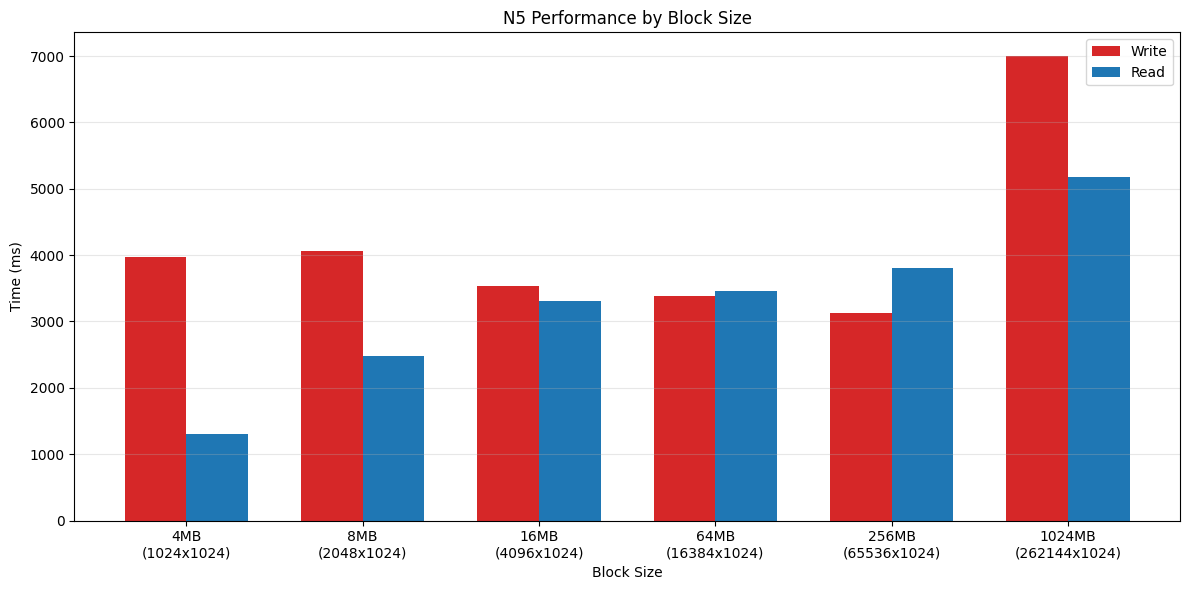

In [9]:
total_size_mb = 1024
block_sizes_mb = [1, 4, 16, 64, 256, 1024]
data_type = 'int32'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'none'
file_io_limit = 'shared'
file_io_sync = True

write_times = []
read_times = []
block_dims_list = []

for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])
    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    write_times.append(write_time)
    
for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])
    read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

N5 write - Block: (1024, 1024) - Time: 4047ms
N5 write - Block: (2048, 1024) - Time: 3769ms
N5 write - Block: (4096, 1024) - Time: 3682ms
N5 write - Block: (16384, 1024) - Time: 3683ms
N5 write - Block: (65536, 1024) - Time: 3503ms
N5 write - Block: (262144, 1024) - Time: 7557ms
N5 read - Block: (1024, 1024) - Time: 1525ms
N5 read - Block: (2048, 1024) - Time: 2636ms
N5 read - Block: (4096, 1024) - Time: 3315ms
N5 read - Block: (16384, 1024) - Time: 3610ms
N5 read - Block: (65536, 1024) - Time: 3707ms
N5 read - Block: (262144, 1024) - Time: 5365ms


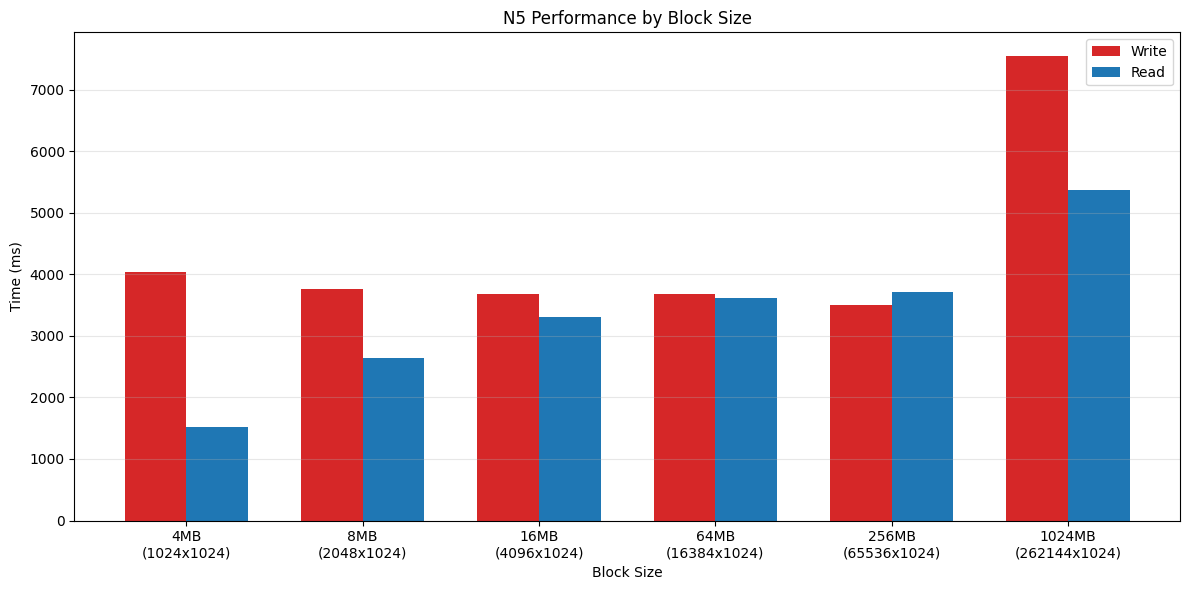

In [7]:
# trial 2
total_size_mb = 1024
# block_sizes_mb = [1, 4, 16, 16, 64, 256, 1024]
block_sizes_mb = [4, 8, 16, 64, 256, 1024]
data_type = 'int32'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'none'
file_io_limit = 'shared'
file_io_sync = True

write_times = []
read_times = []
block_dims_list = []

for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    
    
    write_times.append(write_time)
    
for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    
    read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
    
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

N5 write - Block: (1024, 1024) - Time: 3797ms
N5 write - Block: (2048, 1024) - Time: 3582ms
N5 write - Block: (4096, 1024) - Time: 3381ms
N5 write - Block: (16384, 1024) - Time: 3392ms
N5 write - Block: (65536, 1024) - Time: 3997ms
N5 write - Block: (262144, 1024) - Time: 7200ms
N5 read - Block: (1024, 1024) - Time: 1297ms
N5 read - Block: (2048, 1024) - Time: 2435ms
N5 read - Block: (4096, 1024) - Time: 3109ms
N5 read - Block: (16384, 1024) - Time: 3349ms
N5 read - Block: (65536, 1024) - Time: 3758ms
N5 read - Block: (262144, 1024) - Time: 5099ms


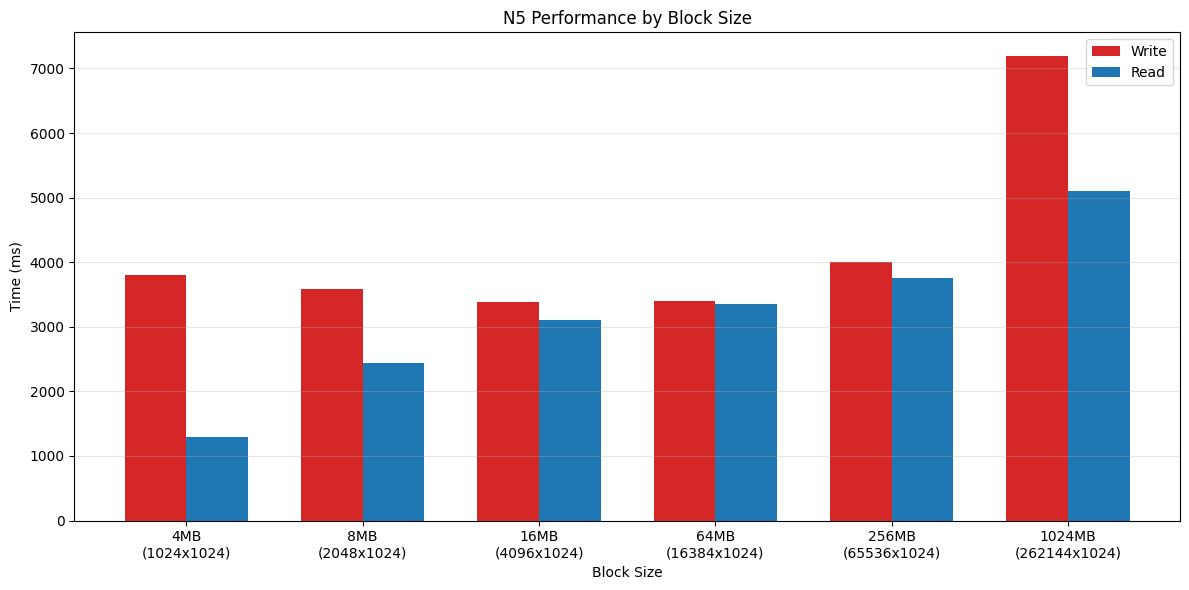

In [8]:
total_size_mb = 1024
# block_sizes_mb = [1, 4, 16, 16, 64, 256, 1024]
block_sizes_mb = [4, 8, 16, 64, 256, 1024]
data_type = 'int32'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'none'
file_io_limit = 'shared'
file_io_sync = True

write_times = []
read_times = []
block_dims_list = []

for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    write_times.append(write_time)
    
for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])
    
    read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

In [ ]:
total_size_mb = 2048
block_sizes_mb = [1, 4, 16, 16, 64, 256, 1024]  
data_type = 'int32'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'none'
file_io_limit = 'shared'
file_io_sync = True

write_times = []
read_times = []
block_dims_list = []

for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    write_times.append(write_time)
    
for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])
    
    read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

## file_io_sync set to True

N5 write - Block: (1024, 1024) - Time: 3264ms
N5 write - Block: (4096, 1024) - Time: 2870ms
N5 write - Block: (16384, 1024) - Time: 2921ms
N5 write - Block: (65536, 1024) - Time: 2869ms
N5 write - Block: (262144, 1024) - Time: 6743ms
N5 read - Block: (1024, 1024) - Time: 1163ms
N5 read - Block: (4096, 1024) - Time: 2809ms
N5 read - Block: (16384, 1024) - Time: 3062ms
N5 read - Block: (65536, 1024) - Time: 3339ms
N5 read - Block: (262144, 1024) - Time: 5593ms


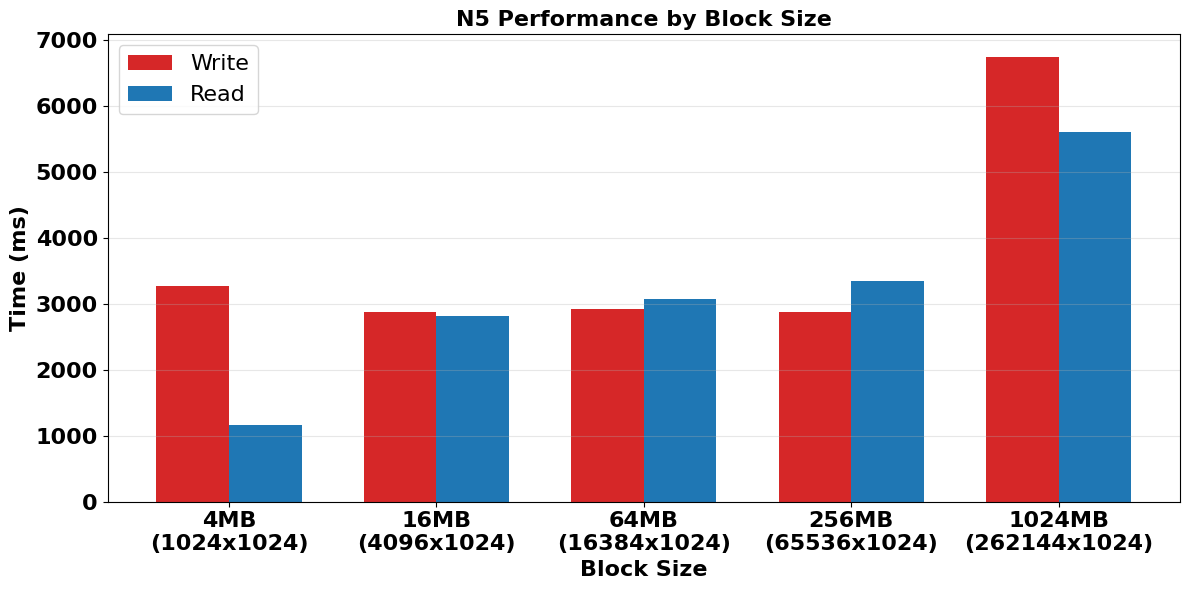

In [23]:
total_size_mb = 1024
block_sizes_mb = [4, 16, 64, 256, 1024]  
data_type = 'int32'
driver_path = 'dataset/improved/n5'
compression = 'none'
file_io_limit = 'shared'
file_io_sync = True

write_times = []
read_times = []
block_dims_list = []

for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    write_times.append(write_time)
    
for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])
    
    read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

## file_io_sync set to False

N5 write - Block: (512, 1024) - Time: 1913ms
N5 write - Block: (2048, 1024) - Time: 1953ms
N5 write - Block: (8192, 1024) - Time: 2105ms
N5 write - Block: (32768, 1024) - Time: 1976ms
N5 write - Block: (131072, 1024) - Time: 3880ms
N5 read - Block: (512, 1024) - Time: 1098ms
N5 read - Block: (2048, 1024) - Time: 1823ms
N5 read - Block: (8192, 1024) - Time: 2001ms
N5 read - Block: (32768, 1024) - Time: 2061ms
N5 read - Block: (131072, 1024) - Time: 3302ms


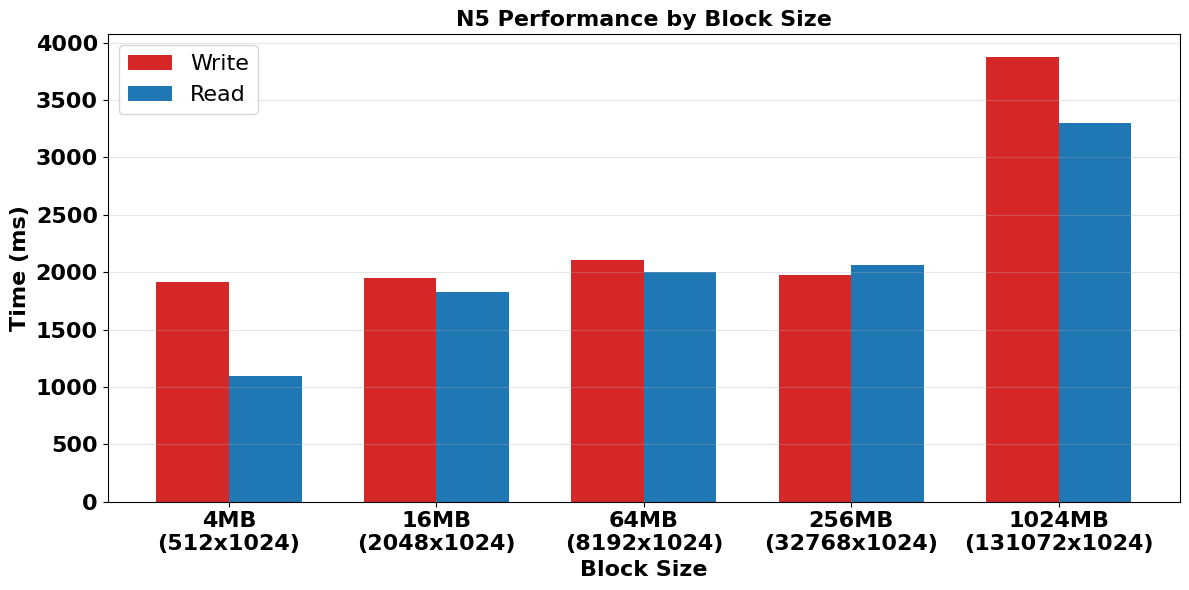

In [24]:
total_size_mb = 1024
block_sizes_mb = [4, 16, 64, 256, 1024] 
data_type = 'int64'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'none'
file_io_limit = 'shared'
file_io_sync = False

write_times = []
read_times = []
block_dims_list = []

for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    write_times.append(write_time)
    
for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])
    
    read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

## compressing with gzip

N5 write - Block: (256, 1024) - Time: 2614ms
N5 read - Block: (256, 1024) - Time: 179ms
N5 write - Block: (512, 1024) - Time: 2566ms
N5 read - Block: (512, 1024) - Time: 193ms
N5 write - Block: (1024, 1024) - Time: 2635ms
N5 read - Block: (1024, 1024) - Time: 230ms
N5 write - Block: (2048, 1024) - Time: 2826ms
N5 read - Block: (2048, 1024) - Time: 551ms
N5 write - Block: (4096, 1024) - Time: 2902ms
N5 read - Block: (4096, 1024) - Time: 745ms
N5 write - Block: (8192, 1024) - Time: 3216ms
N5 read - Block: (8192, 1024) - Time: 736ms
N5 write - Block: (16384, 1024) - Time: 3240ms
N5 read - Block: (16384, 1024) - Time: 848ms
N5 write - Block: (32768, 1024) - Time: 5405ms
N5 read - Block: (32768, 1024) - Time: 1021ms


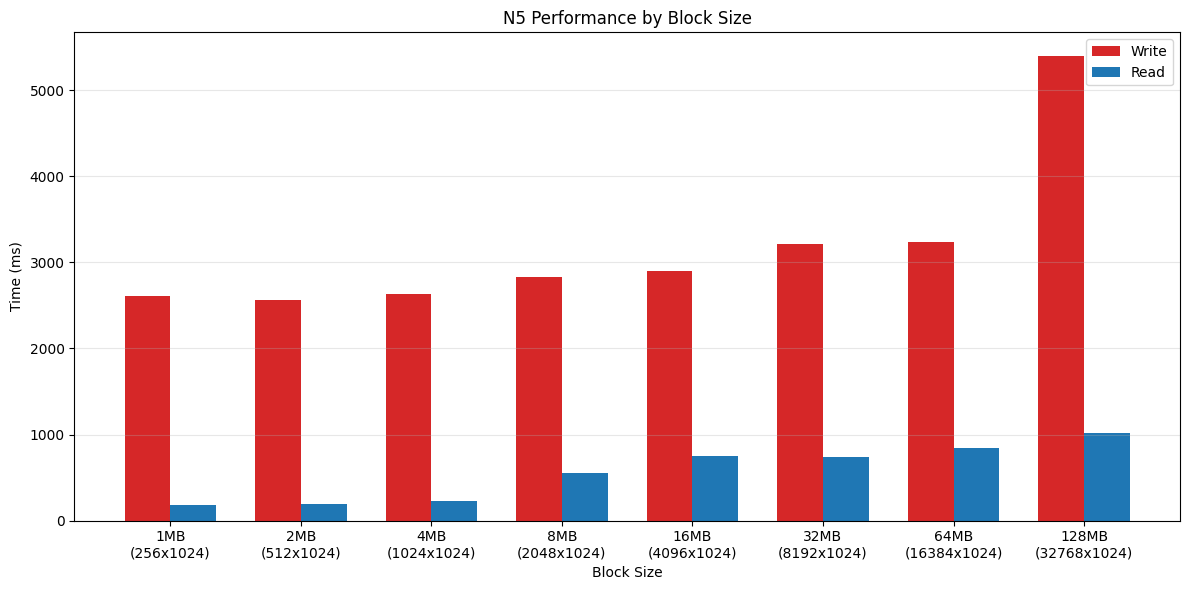

In [6]:
total_size_mb = 256
block_sizes_mb = [1, 2, 4, 8, 16, 32, 64, 128]  
data_type = 'int32'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'gzip'
file_io_limit = 'shared'
file_io_sync = True

write_times = []
read_times = []
block_dims_list = []

for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    write_times.append(write_time)
    
for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])
    
    read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

## compressing with bzip2

N5 write - Block: (256, 1024) - Time: 5048ms
N5 read - Block: (256, 1024) - Time: 3928ms
N5 write - Block: (512, 1024) - Time: 5163ms
N5 read - Block: (512, 1024) - Time: 3714ms
N5 write - Block: (1024, 1024) - Time: 5121ms
N5 read - Block: (1024, 1024) - Time: 3655ms
N5 write - Block: (2048, 1024) - Time: 5107ms
N5 read - Block: (2048, 1024) - Time: 4074ms
N5 write - Block: (4096, 1024) - Time: 4996ms
N5 read - Block: (4096, 1024) - Time: 4367ms
N5 write - Block: (8192, 1024) - Time: 4716ms
N5 read - Block: (8192, 1024) - Time: 4648ms
N5 write - Block: (16384, 1024) - Time: 5180ms
N5 read - Block: (16384, 1024) - Time: 5462ms
N5 write - Block: (32768, 1024) - Time: 8847ms
N5 read - Block: (32768, 1024) - Time: 5711ms


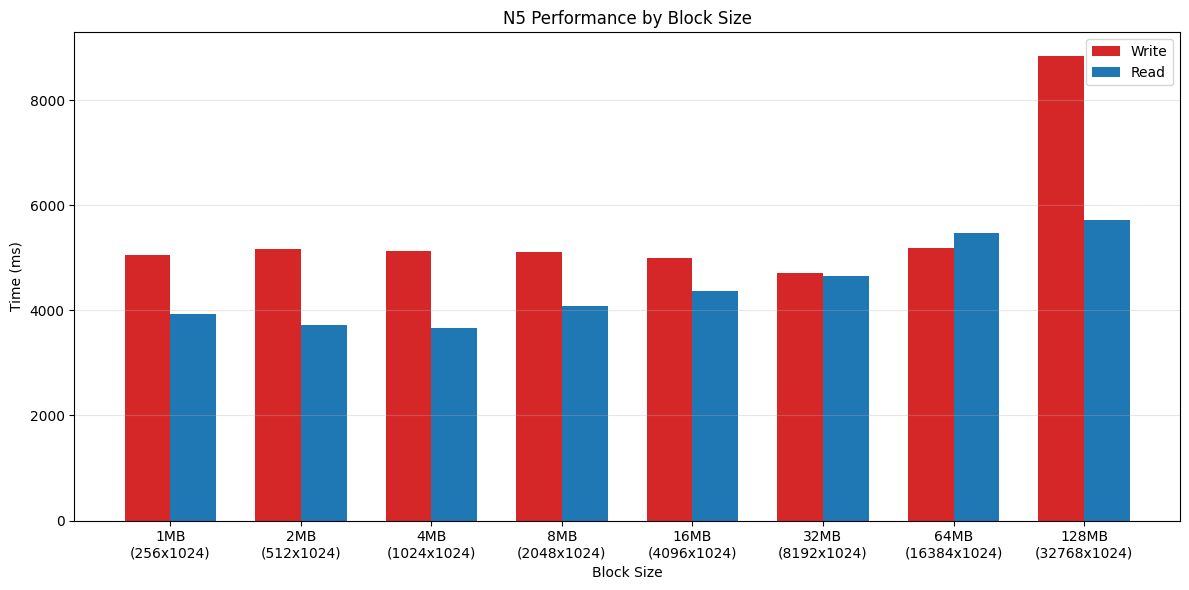

In [7]:
total_size_mb = 256
block_sizes_mb = [1, 2, 4, 8, 16, 32, 64, 128]  
data_type = 'int32'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'bzip2'
file_io_limit = 'shared'
file_io_sync = True

write_times = []
read_times = []
block_dims_list = []

for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    write_times.append(write_time)
    
for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])
    
    read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

## compressing with zstd

N5 write - Block: (256, 1024) - Time: 1439ms
N5 read - Block: (256, 1024) - Time: 180ms
N5 write - Block: (512, 1024) - Time: 1281ms
N5 read - Block: (512, 1024) - Time: 205ms
N5 write - Block: (1024, 1024) - Time: 1492ms
N5 read - Block: (1024, 1024) - Time: 245ms
N5 write - Block: (2048, 1024) - Time: 1477ms
N5 read - Block: (2048, 1024) - Time: 574ms
N5 write - Block: (4096, 1024) - Time: 1444ms
N5 read - Block: (4096, 1024) - Time: 684ms
N5 write - Block: (8192, 1024) - Time: 1287ms
N5 read - Block: (8192, 1024) - Time: 730ms
N5 write - Block: (16384, 1024) - Time: 1498ms
N5 read - Block: (16384, 1024) - Time: 786ms
N5 write - Block: (32768, 1024) - Time: 1822ms
N5 read - Block: (32768, 1024) - Time: 947ms


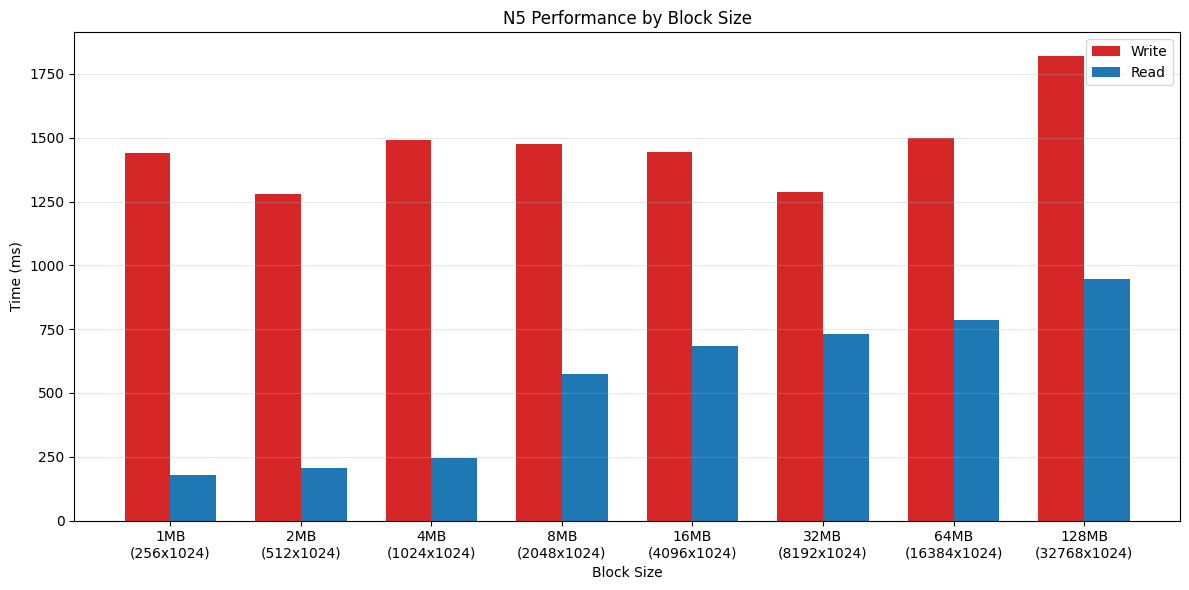

In [8]:
total_size_mb = 256
block_sizes_mb = [1, 2, 4, 8, 16, 32, 64, 128]  
data_type = 'int32'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'zstd'
file_io_limit = 'shared'
file_io_sync = True

write_times = []
read_times = []
block_dims_list = []

for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    write_times.append(write_time)
    
for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])
    
    read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

## comparing 3 compression algorithms for write and read


--- testing compression: gzip ---
N5 write - Block: (1024, 1024) - Time: 9082ms
N5 write - Block: (4096, 1024) - Time: 9357ms
N5 write - Block: (16384, 1024) - Time: 9199ms
N5 write - Block: (65536, 1024) - Time: 11818ms
N5 write - Block: (262144, 1024) - Time: 39435ms
N5 read - Block: (1024, 1024) - Time: 875ms
N5 read - Block: (4096, 1024) - Time: 2764ms
N5 read - Block: (16384, 1024) - Time: 2916ms
N5 read - Block: (65536, 1024) - Time: 3267ms
N5 read - Block: (262144, 1024) - Time: 5673ms

--- testing compression: bzip2 ---
N5 write - Block: (1024, 1024) - Time: 17611ms
N5 write - Block: (4096, 1024) - Time: 18795ms
N5 write - Block: (16384, 1024) - Time: 18368ms
N5 write - Block: (65536, 1024) - Time: 20328ms
N5 write - Block: (262144, 1024) - Time: 63135ms
N5 read - Block: (1024, 1024) - Time: 15878ms
N5 read - Block: (4096, 1024) - Time: 18865ms
N5 read - Block: (16384, 1024) - Time: 19432ms
N5 read - Block: (65536, 1024) - Time: 23324ms
N5 read - Block: (262144, 1024) - Time: 

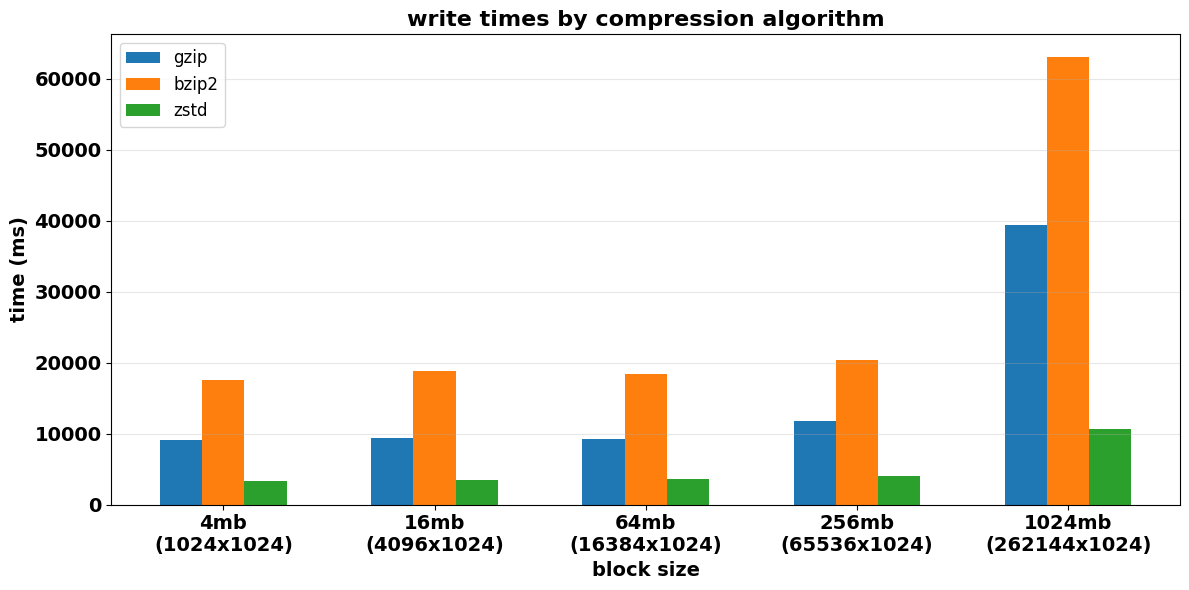

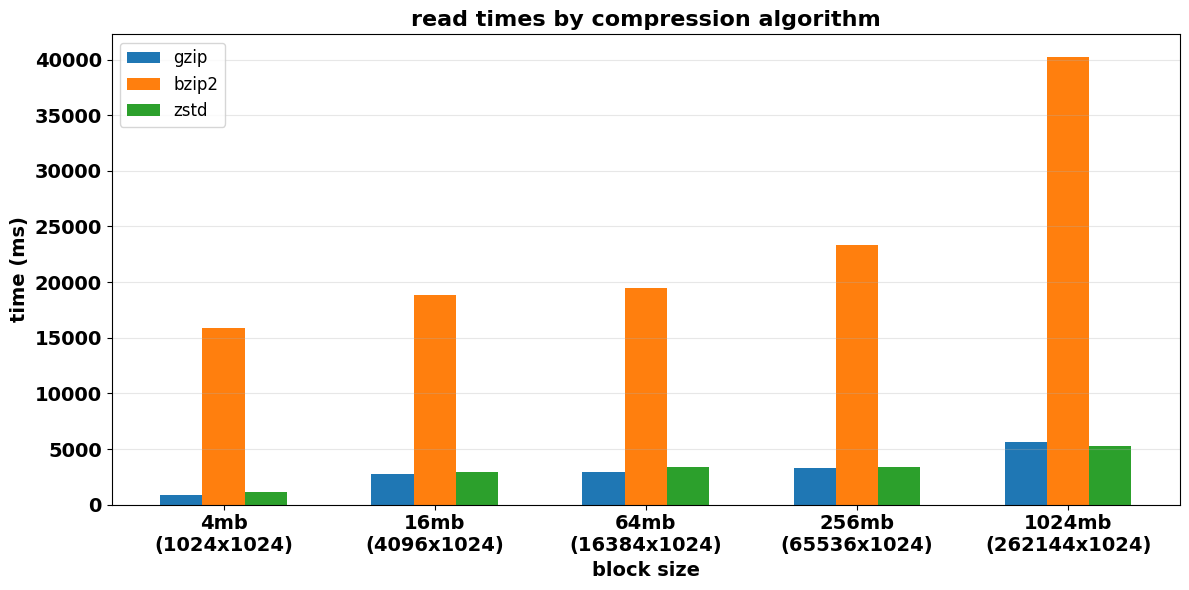

In [18]:
import matplotlib.pyplot as plt

# define core configuration values
total_size_mb = 1024
block_sizes_mb = [4, 16, 64, 256, 1024]
data_type = 'int32'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression_algos = ['gzip', 'bzip2', 'zstd']
file_io_limit = 'shared'
file_io_sync = True

# store total write and read times for each compression type
write_times_dict = {algo: [] for algo in compression_algos}
read_times_dict = {algo: [] for algo in compression_algos}
block_dims_list = []

# loop through each compression type and collect timings
for compression in compression_algos:
    print(f"\n--- testing compression: {compression} ---")
    for block_mb in block_sizes_mb:
        dims = calculate_dimensions(total_size_mb, block_mb, data_type)
        if compression == compression_algos[0]:  # only record dims once
            block_dims_list.append(dims[1])
        
        write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
        write_times_dict[compression].append(write_time)

    for block_mb in block_sizes_mb:
        dims = calculate_dimensions(total_size_mb, block_mb, data_type)
        read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
        read_times_dict[compression].append(read_time)

# plotting function for write and read times
def plot_times(title, ylabel, times_dict, block_sizes_mb):
    plt.figure(figsize=(12, 6))
    x = range(len(block_sizes_mb))
    width = 0.2

    for i, (algo, times) in enumerate(times_dict.items()):
        offset = (i - 1) * width
        plt.bar([xi + offset for xi in x], times, width, label=algo)

    plt.xticks(
        ticks=x, 
        labels=[f"{mb}mb\n({dims[0]}x{dims[1]})" for mb, dims in zip(block_sizes_mb, block_dims_list)],
        fontsize=14, fontweight='bold'
    )
    plt.yticks(fontsize=14, fontweight='bold')
    plt.xlabel("block size", fontsize=14, fontweight='bold')
    plt.ylabel(ylabel, fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# plot write times
plot_times("write times by compression algorithm", "time (ms)", write_times_dict, block_sizes_mb)

# plot read times
plot_times("read times by compression algorithm", "time (ms)", read_times_dict, block_sizes_mb)


## changing datatype to int8

N5 write - Block: (1024, 1024) - Time: 3525ms
N5 read - Block: (1024, 1024) - Time: 295ms
N5 write - Block: (2048, 1024) - Time: 3356ms
N5 read - Block: (2048, 1024) - Time: 333ms
N5 write - Block: (4096, 1024) - Time: 3074ms
N5 read - Block: (4096, 1024) - Time: 499ms
N5 write - Block: (8192, 1024) - Time: 3264ms
N5 read - Block: (8192, 1024) - Time: 1244ms
N5 write - Block: (16384, 1024) - Time: 3420ms
N5 read - Block: (16384, 1024) - Time: 2207ms
N5 write - Block: (32768, 1024) - Time: 3340ms
N5 read - Block: (32768, 1024) - Time: 2568ms
N5 write - Block: (65536, 1024) - Time: 5227ms
N5 read - Block: (65536, 1024) - Time: 3240ms
N5 write - Block: (131072, 1024) - Time: 4563ms
N5 read - Block: (131072, 1024) - Time: 3561ms


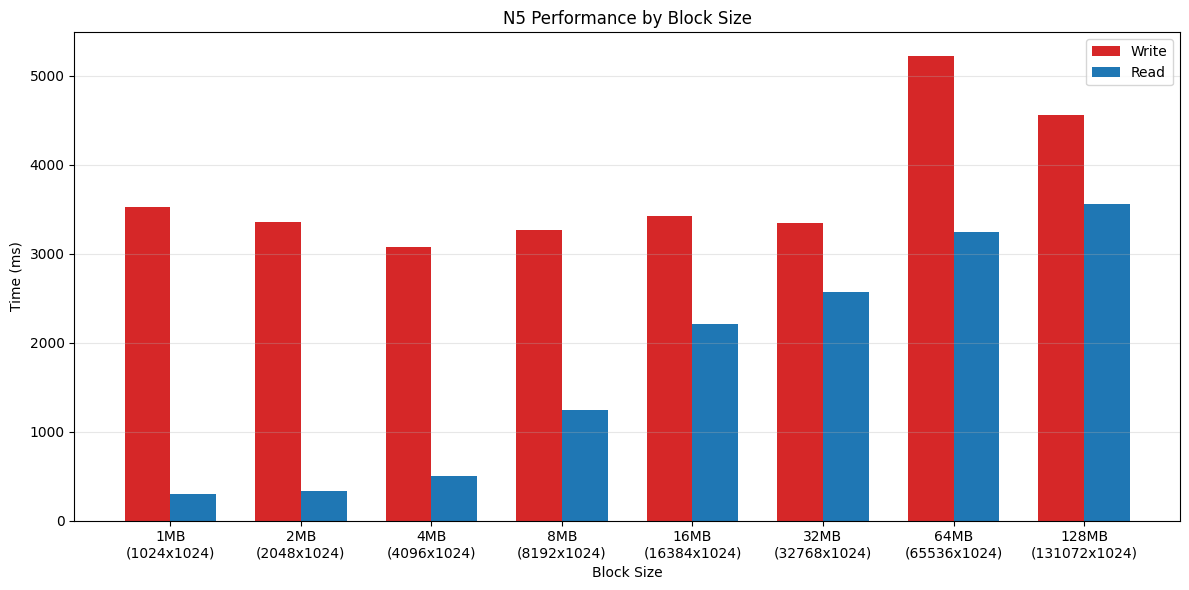

In [9]:
total_size_mb = 256
block_sizes_mb = [1, 2, 4, 8, 16, 32, 64, 128]  
data_type = 'int8'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'none'
file_io_limit = 'shared'
file_io_sync = True

write_times = []
read_times = []
block_dims_list = []

for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
    
    write_times.append(write_time)
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

## changing datatype to float32

N5 write - Block: (256, 1024) - Time: 1354ms
N5 read - Block: (256, 1024) - Time: 238ms
N5 write - Block: (512, 1024) - Time: 1286ms
N5 read - Block: (512, 1024) - Time: 250ms
N5 write - Block: (1024, 1024) - Time: 1343ms
N5 read - Block: (1024, 1024) - Time: 336ms
N5 write - Block: (2048, 1024) - Time: 1315ms
N5 read - Block: (2048, 1024) - Time: 589ms
N5 write - Block: (4096, 1024) - Time: 1342ms
N5 read - Block: (4096, 1024) - Time: 731ms
N5 write - Block: (8192, 1024) - Time: 1495ms
N5 read - Block: (8192, 1024) - Time: 921ms
N5 write - Block: (16384, 1024) - Time: 1480ms
N5 read - Block: (16384, 1024) - Time: 911ms
N5 write - Block: (32768, 1024) - Time: 1569ms
N5 read - Block: (32768, 1024) - Time: 840ms


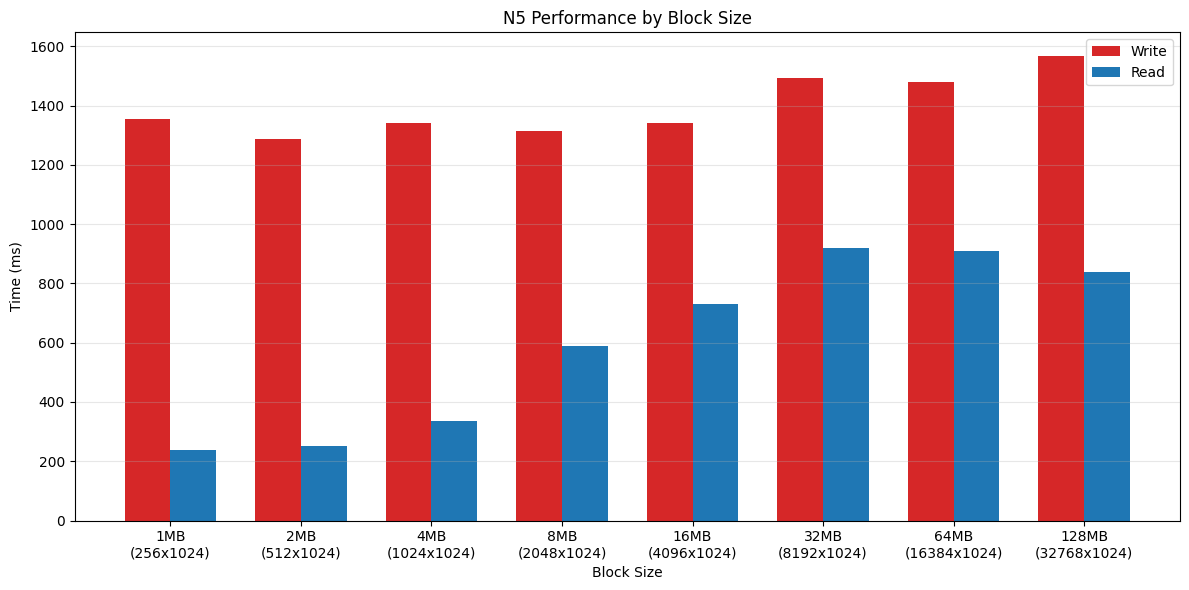

In [10]:
total_size_mb = 256
block_sizes_mb = [1, 2, 4, 8, 16, 32, 64, 128]  
data_type = 'float32'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'none'
file_io_limit = 'shared'
file_io_sync = True

write_times = []
read_times = []
block_dims_list = []

for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
    
    write_times.append(write_time)
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

## changing datatype to float64

In [ ]:
total_size_mb = 256
block_sizes_mb = [1, 2, 4, 8, 16, 32, 64, 128]  
data_type = 'float64'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'none'
file_io_limit = 'shared'
file_io_sync = True

write_times = []
read_times = []
block_dims_list = []

for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
    
    write_times.append(write_time)
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

## comparing 5 datatypes - 'int8', 'int16', 'int32', 'float32', 'float64'


--- testing data type: int8 ---
N5 write - Block: (4096, 1024) - Time: 16949ms
N5 write - Block: (16384, 1024) - Time: 15070ms
N5 write - Block: (65536, 1024) - Time: 15001ms
N5 write - Block: (262144, 1024) - Time: 14628ms
N5 write - Block: (1048576, 1024) - Time: 27201ms
N5 read - Block: (4096, 1024) - Time: 1889ms
N5 read - Block: (16384, 1024) - Time: 8941ms
N5 read - Block: (65536, 1024) - Time: 10299ms
N5 read - Block: (262144, 1024) - Time: 12494ms
N5 read - Block: (1048576, 1024) - Time: 17838ms

--- testing data type: int16 ---
N5 write - Block: (2048, 1024) - Time: 6149ms
N5 write - Block: (8192, 1024) - Time: 5899ms
N5 write - Block: (32768, 1024) - Time: 7452ms
N5 write - Block: (131072, 1024) - Time: 8538ms
N5 write - Block: (524288, 1024) - Time: 14040ms
N5 read - Block: (2048, 1024) - Time: 1387ms
N5 read - Block: (8192, 1024) - Time: 4825ms
N5 read - Block: (32768, 1024) - Time: 5522ms
N5 read - Block: (131072, 1024) - Time: 7084ms
N5 read - Block: (524288, 1024) - Tim

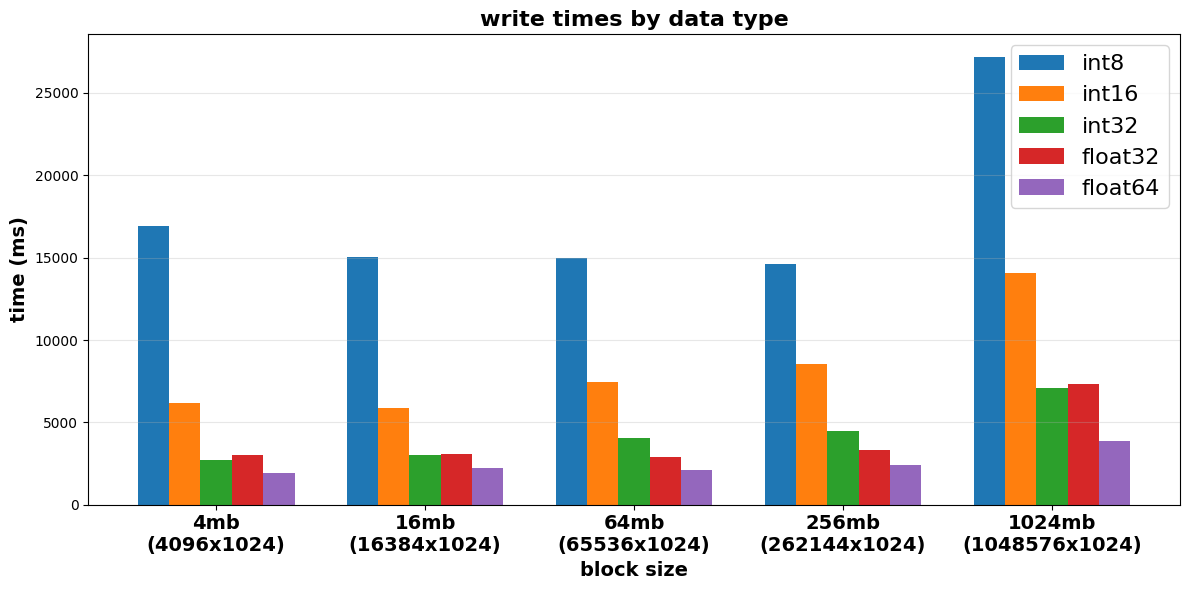

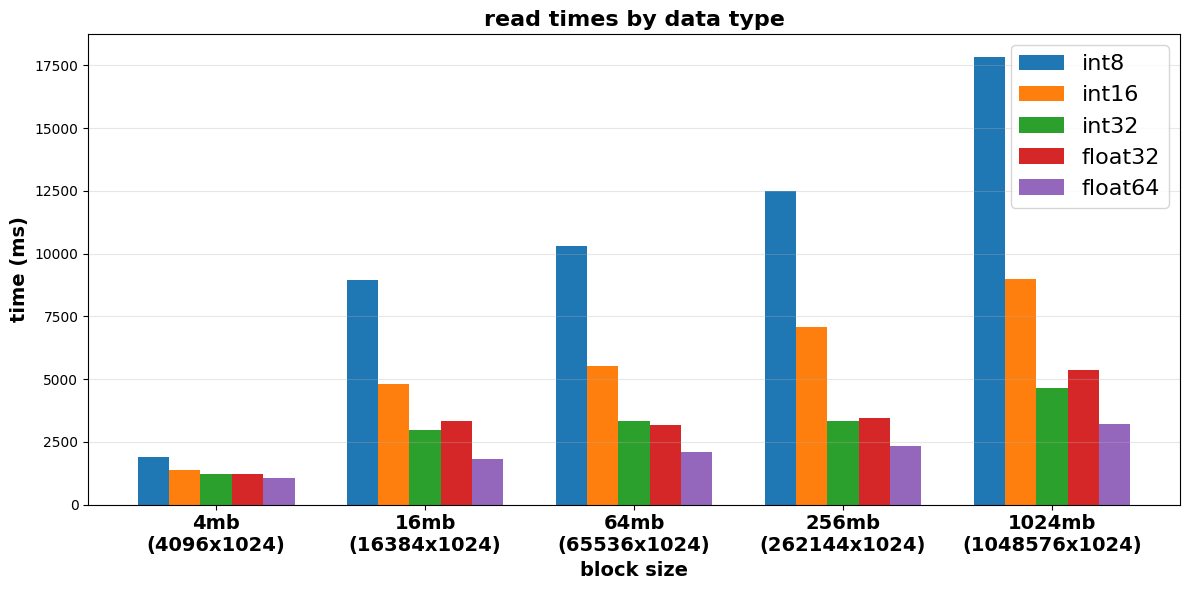

In [21]:
import matplotlib.pyplot as plt

# define core configuration values
total_size_mb = 1024
block_sizes_mb = [4, 16, 64, 256, 1024]  
data_types = ['int8', 'int16', 'int32', 'float32', 'float64']
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'none'
file_io_limit = 'shared'
file_io_sync = True

# store total write and read times for each data type
write_times_dict = {dtype: [] for dtype in data_types}
read_times_dict = {dtype: [] for dtype in data_types}
block_dims_list = []

# loop through each data type and collect timings
for data_type in data_types:
    print(f"\n--- testing data type: {data_type} ---")
    for block_mb in block_sizes_mb:
        dims = calculate_dimensions(total_size_mb, block_mb, data_type)
        if data_type == data_types[0]:  # only record dims once
            block_dims_list.append(dims[1])

        write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
        write_times_dict[data_type].append(write_time)

    for block_mb in block_sizes_mb:
        dims = calculate_dimensions(total_size_mb, block_mb, data_type)
        read_time = read_tensor(driver, file, driver_path, dims[1], file_io_limit, file_io_sync)
        read_times_dict[data_type].append(read_time)

# plotting function for write and read times
def plot_times(title, ylabel, times_dict, block_sizes_mb):
    plt.figure(figsize=(12, 6))
    x = range(len(block_sizes_mb))
    width = 0.15

    for i, (dtype, times) in enumerate(times_dict.items()):
        offset = (i - len(times_dict) / 2) * width + width / 2
        plt.bar([xi + offset for xi in x], times, width, label=dtype)

    plt.xticks(
        ticks=x, 
        labels=[f"{mb}mb\n({dims[0]}x{dims[1]})" for mb, dims in zip(block_sizes_mb, block_dims_list)],
        fontsize=14, fontweight='bold'
    )
    plt.xlabel("block size", fontsize=14, fontweight='bold')
    plt.ylabel(ylabel, fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(fontsize=16)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# plot write times
plot_times("write times by data type", "time (ms)", write_times_dict, block_sizes_mb)

# plot read times
plot_times("read times by data type", "time (ms)", read_times_dict, block_sizes_mb)


## writing to Google Cloud

I0502 20:18:27.201028  388286 google_auth_provider.cc:149] Using credentials at /home/rifatxia/.config/gcloud/application_default_credentials.json
I0502 20:18:27.201167  388286 google_auth_provider.cc:156] Using OAuth2 AuthProvider


N5 write - Block: (1024, 1024) - Time: 88931ms
N5 write - Block: (4096, 1024) - Time: 88659ms
N5 write - Block: (16384, 1024) - Time: 91334ms
N5 write - Block: (65536, 1024) - Time: 88283ms
N5 write - Block: (262144, 1024) - Time: 96680ms
N5 read - Block: (1024, 1024) - Time: 46675ms
N5 read - Block: (4096, 1024) - Time: 46411ms
N5 read - Block: (16384, 1024) - Time: 47518ms
N5 read - Block: (65536, 1024) - Time: 47969ms
N5 read - Block: (262144, 1024) - Time: 50576ms


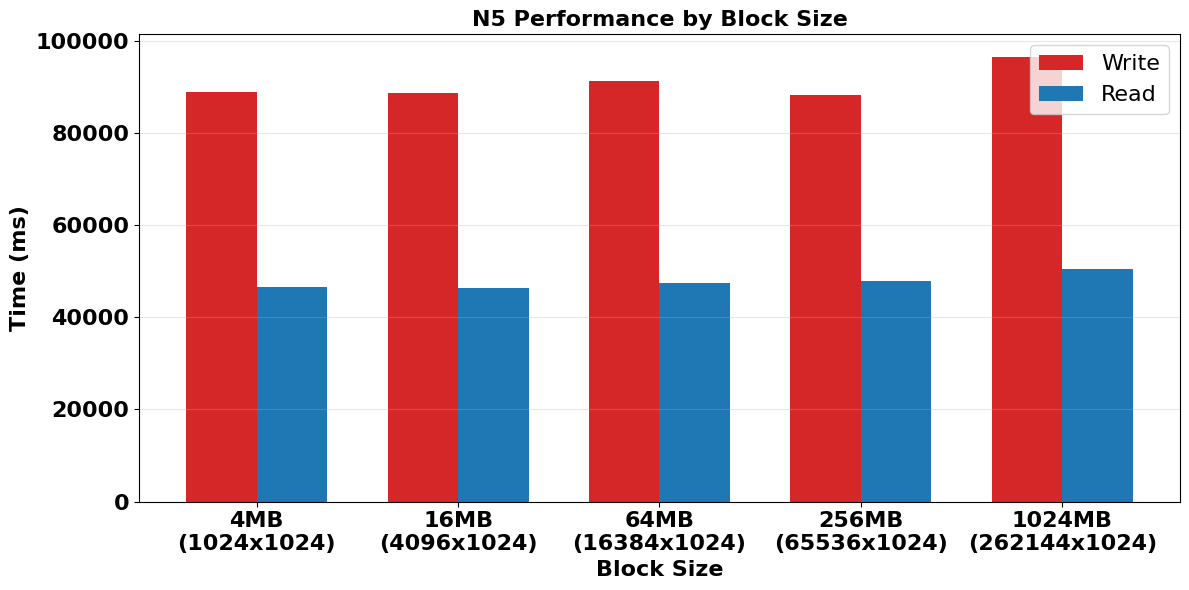

In [3]:
total_size_mb = 1024
block_sizes_mb = [4, 16, 64, 256, 1024]
data_type = 'int32'
driver = 'n5'
file = 'gcs'
driver_path = 'cs550-project-bucket'
compression = 'none'
file_io_limit = 'shared'
file_io_sync = True

write_times = []
read_times = []
block_dims_list = []

# Precompute dimensions and store block dims
for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    block_dims_list.append(dims[1])

    # Perform write
    write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, file_io_limit, file_io_sync)
    write_times.append(write_time)

# Perform reads separately using the stored block dimensions
for block_dim in block_dims_list:
    read_time = read_tensor(driver, file, driver_path, block_dim, file_io_limit, file_io_sync)
    read_times.append(read_time)

plot_results(block_sizes_mb, block_dims_list, write_times, read_times)

## changing file_io_concurrency


--- testing block size: 4mb (1024x1024) ---
N5 write - Block: (1024, 1024) - Time: 2737ms
N5 write - Block: (1024, 1024) - Time: 2963ms
N5 write - Block: (1024, 1024) - Time: 2634ms
N5 write - Block: (1024, 1024) - Time: 2568ms
N5 write - Block: (1024, 1024) - Time: 2781ms
N5 write - Block: (1024, 1024) - Time: 2668ms
N5 read - Block: (1024, 1024) - Time: 1058ms
N5 read - Block: (1024, 1024) - Time: 1036ms
N5 read - Block: (1024, 1024) - Time: 1051ms
N5 read - Block: (1024, 1024) - Time: 1114ms
N5 read - Block: (1024, 1024) - Time: 1050ms
N5 read - Block: (1024, 1024) - Time: 1045ms

--- testing block size: 16mb (4096x1024) ---
N5 write - Block: (4096, 1024) - Time: 2910ms
N5 write - Block: (4096, 1024) - Time: 2830ms
N5 write - Block: (4096, 1024) - Time: 2907ms
N5 write - Block: (4096, 1024) - Time: 2821ms
N5 write - Block: (4096, 1024) - Time: 2931ms
N5 write - Block: (4096, 1024) - Time: 2992ms
N5 read - Block: (4096, 1024) - Time: 2927ms
N5 read - Block: (4096, 1024) - Time: 2860

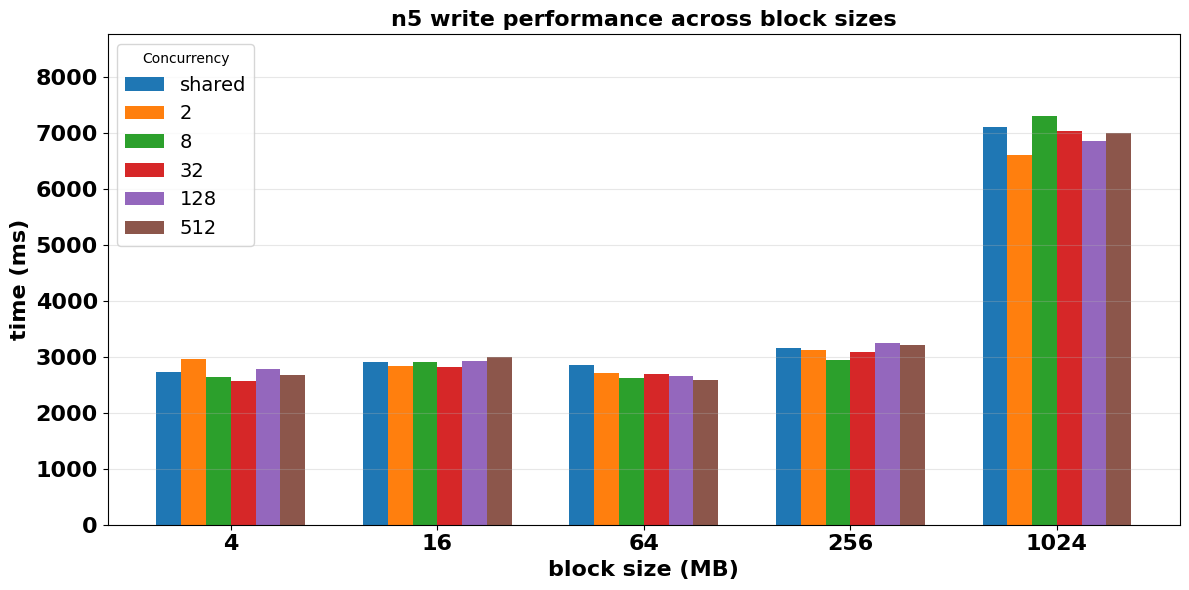

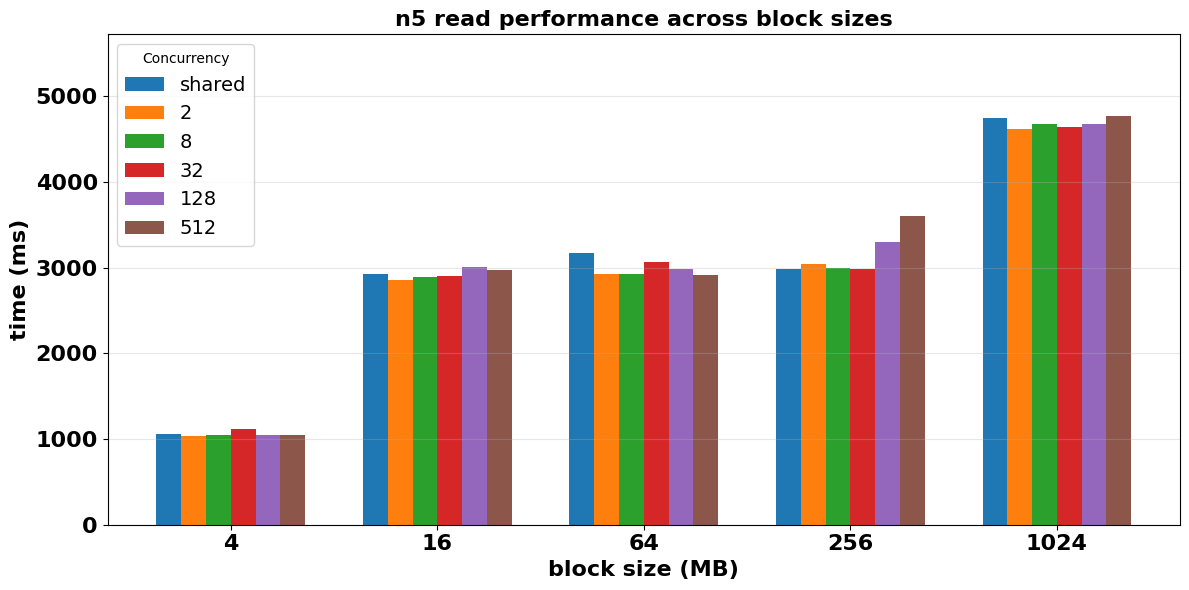

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# define parameters
total_size_mb = 1024
block_sizes_mb = [4, 16, 64, 256, 1024]
data_type = 'int32'
driver = 'n5'
file = 'file'
driver_path = 'dataset/improved/n5'
compression = 'none'
file_io_sync = True
file_io_concurrency_values = ['shared', 2, 8, 32, 128, 512]

# initialize dictionaries to store times for each concurrency level
write_times_by_concurrency = {str(c): [] for c in file_io_concurrency_values}
read_times_by_concurrency = {str(c): [] for c in file_io_concurrency_values}

# loop over each block size
for block_mb in block_sizes_mb:
    dims = calculate_dimensions(total_size_mb, block_mb, data_type)
    print(f"\n--- testing block size: {block_mb}mb ({dims[1][0]}x{dims[1][1]}) ---")

    # write timings
    for concurrency in file_io_concurrency_values:
        write_time = write_tensor(driver, file, driver_path, data_type, *dims, compression, concurrency, file_io_sync)
        write_times_by_concurrency[str(concurrency)].append(write_time)

    # read timings
    for concurrency in file_io_concurrency_values:
        read_time = read_tensor(driver, file, driver_path, dims[1], concurrency, file_io_sync)
        read_times_by_concurrency[str(concurrency)].append(read_time)

# Function to plot grouped bar chart
def plot_grouped_bars(times_by_concurrency, operation_type):
    bar_width = 0.12
    x = np.arange(len(block_sizes_mb))  # index positions for block sizes

    plt.figure(figsize=(12, 6))

    all_values = []

    # Plot each concurrency group with offset
    for i, concurrency in enumerate(file_io_concurrency_values):
        offset = (i - len(file_io_concurrency_values) / 2) * bar_width + bar_width / 2
        values = times_by_concurrency[str(concurrency)]
        all_values.extend(values)
        plt.bar(x + offset, values, width=bar_width, label=f'{concurrency}')

    # Padding on top of the y-axis
    max_val = max(all_values)
    y_limit = max_val * 1.2 # adjusting for avoiding overlap of the legend and the plots

    # Set labels and ticks
    plt.xlabel('block size (MB)', fontsize=16, fontweight='bold')
    plt.ylabel('time (ms)', fontsize=16, fontweight='bold')
    plt.title(f'n5 {operation_type} performance across block sizes', fontsize=16, fontweight='bold')
    plt.xticks(x, [str(b) for b in block_sizes_mb], fontsize=16, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')
    plt.ylim(0, y_limit)
    plt.legend(title='Concurrency', fontsize=14, loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


# Plot write and read performance
plot_grouped_bars(write_times_by_concurrency, 'write')
plot_grouped_bars(read_times_by_concurrency, 'read')
